In [1]:
%matplotlib inline

import os
import re
import sys
import yaml
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## slower, more reproducible
#cudnn.benchmark, cudnn.deterministic = False, True
## faster, less reproducible
#cudnn.benchmark, cudnn.deterministic = True, False

In [2]:

%load_ext autoreload
%autoreload 2

sys.path.append('../../../')
from video_processing.yolov7.parameter_parser import parser
from video_processing.yolov7.dataset.coco_dataset import LoadImagesAndLabels

In [3]:
data_dirpath='D:/data/coco'
result_dirpath='D:/results/yolov7'

argument=f"""--data-dirpath {data_dirpath}/coco --output-dirpath {result_dirpath} 
--worker 1 --device cpu --batch-size 2 --data coco.yaml --img 1280 1280 --cfg yolov7-w6.yaml
--weights ''  --name yolov7-w6 --hyp hyp.scratch.p6.yaml 
--n-training-data 100 --n-val-data 20 --correct-exif """
args=parser.parse_args(argument.split())

In [4]:
# hyperparameters
with open(args.hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
# data
with open(args.data) as f: data_dict=yaml.load(f, Loader=yaml.SafeLoader)

In [5]:
dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['val'], img_size=args.img_size[0],
                            augment=False, hyp=hyp, n_data=args.n_training_data, correct_exif=args.correct_exif)
# dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['train'], img_size=args.img_size[0],
#                             augment=True, hyp=hyp, n_data=args.n_training_data, correct_exif=args.correct_exif)
img, labels, fpath, shapes=dataset[0]
print('img ', img.dtype, img.shape, img.min().item(), img.max().item())
print('labels ', labels.dtype, labels.shape, end=',')
if len(labels)>0: print(labels[:,1], labels[:,2:].min().item(), labels[:,2:].max().item())
print('fpath ', fpath)

In dataset.coco_dataset.__init__ save cache to D:\data\coco\coco\labels\val2017.cache cache_path.is_file() True
img  torch.uint8 torch.Size([3, 1280, 1280]) 0 255
labels  torch.float32 torch.Size([25, 6]),tensor([39., 60.,  0., 39., 39., 48., 45., 45., 45., 55., 55.,  0., 44., 45.,
        45., 45., 45., 45., 45., 45., 69., 39., 41., 45., 48.]) 0.007921457290649414 0.9804609417915344
fpath  D:\data\coco\coco\images\val2017\000000182611.jpg


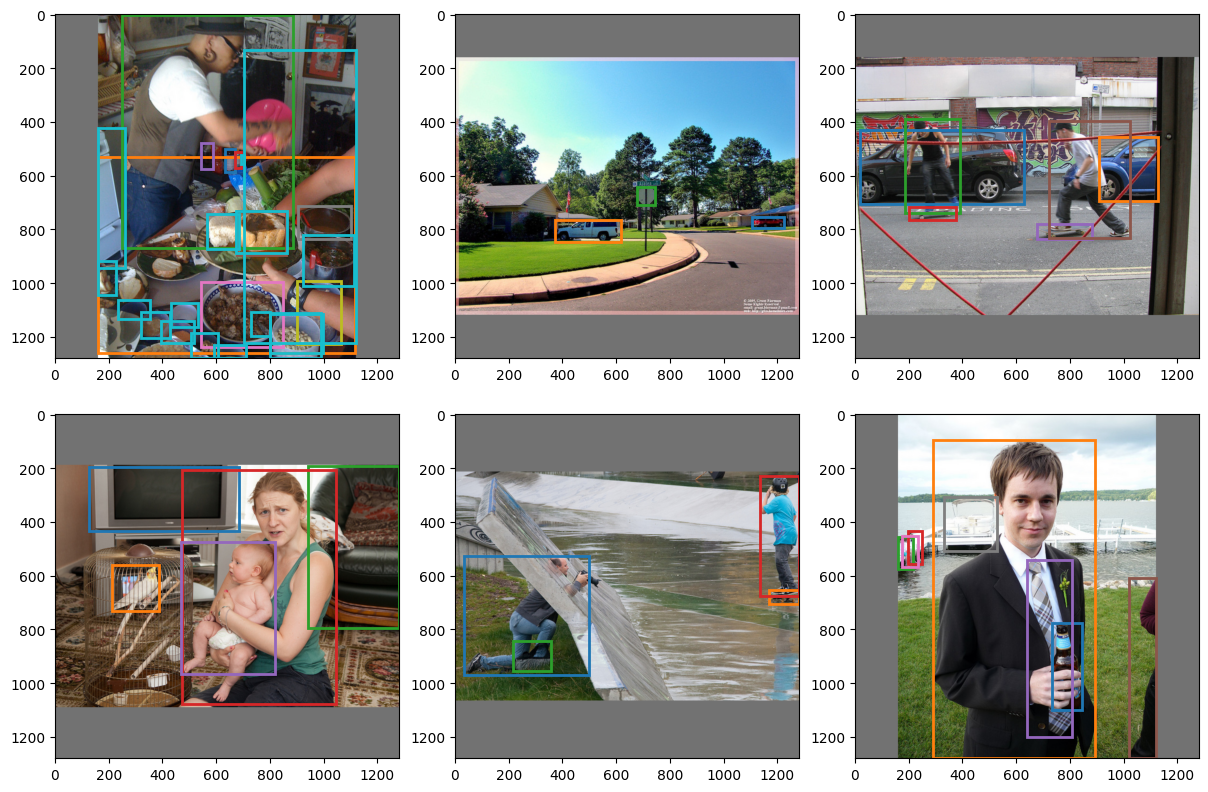

In [6]:
from matplotlib import patches
from video_processing.yolov7.dataset.coords import normalized_xywh2xyxy

n_datas=6
n_cols=3
n_rows=int(np.ceil(n_datas/n_cols))

cmap = plt.get_cmap('tab10', 10)

_, ax=plt.subplots(n_rows,n_cols,figsize=(12,8))
for r in range(n_rows):
    for c in range(n_cols):
        idx=r*n_cols+c
        image, labels, fpath=dataset[idx]
        ax[r,c].imshow(image.permute(1,2,0)) # CxHxW to HxWxC
        labels=labels[:,2:] # ignore the unknow first column, and class object in the second column 
        boxes= normalized_xywh2xyxy(labels,w=image.shape[-1], h=image.shape[1])
        for i, box in enumerate(boxes):
            # Create a Rectangle patch
            rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(i), facecolor='none')
            # Add the patch to the Axes
            ax[r,c].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

In [7]:
data_loader=torch.utils.data.DataLoader(dataset=dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True, 
                                        collate_fn=LoadImagesAndLabels.collate_fn)
imgs, labels, fpath=next(iter(data_loader))
print('imgs ', imgs.shape, imgs.dtype, imgs.min().item(), imgs.max().item())
print('labels ', labels.shape, labels.dtype, labels[:,1])
print('fpath ', type(fpath), len(fpath))

imgs  torch.Size([2, 3, 1280, 1280]) torch.uint8 0 255
labels  torch.Size([28, 6]) torch.float32 tensor([39., 60.,  0., 39., 39., 48., 45., 45., 45., 55., 55.,  0., 44., 45.,
        45., 45., 45., 45., 45., 45., 69., 39., 41., 45., 48.,  2.,  7., 11.])
fpath  <class 'tuple'> 2



 0  boxes  torch.Size([25, 4]), j  0  box  torch.Size([4]), j  1  box  torch.Size([4]), j  2  box  torch.Size([4]), j  3  box  torch.Size([4]), j  4  box  torch.Size([4]), j  5  box  torch.Size([4]), j  6  box  torch.Size([4]), j  7  box  torch.Size([4]), j  8  box  torch.Size([4]), j  9  box  torch.Size([4]), j  10  box  torch.Size([4]), j  11  box  torch.Size([4]), j  12  box  torch.Size([4]), j  13  box  torch.Size([4]), j  14  box  torch.Size([4]), j  15  box  torch.Size([4]), j  16  box  torch.Size([4]), j  17  box  torch.Size([4]), j  18  box  torch.Size([4]), j  19  box  torch.Size([4]), j  20  box  torch.Size([4]), j  21  box  torch.Size([4]), j  22  box  torch.Size([4]), j  23  box  torch.Size([4]), j  24  box  torch.Size([4]),
 j  0  box  torch.Size([4]), j  1  box  torch.Size([4]), j  2  box  torch.Size([4]),

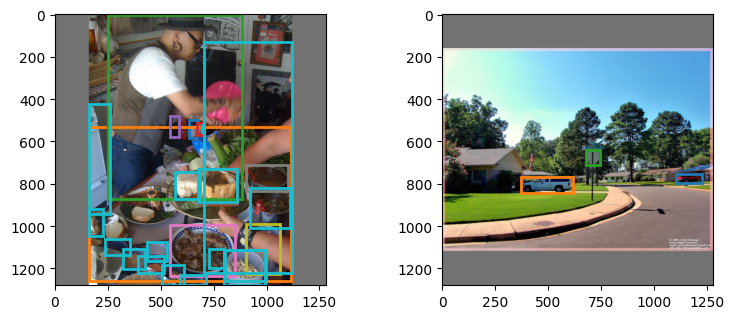

In [8]:
imgs, labels, fpath=next(iter(data_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(8,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    print('\n', i, ' boxes ', boxes.shape, end=',')
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        print(' j ', j, ' box ', box.shape, end=',')
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
